# 分类问题

## 手写数字识别

**图片的表示方法**

一张图片包含了ℎ行(Height/Row)，𝑤列
(Width/Column)，每个位置保存了像素(Pixel)值，像素值一般使用 0~255 的整形数值来表达
颜色强度信息，例如 0 表示强度最低，255 表示强度最高。如果是彩色图片，则每个像素
点包含了 R、G、B 三个通道的强度信息，分别代表红色通道、绿色通道、蓝色通道的颜
色强度，所以与灰度图片不同，它的每个像素点使用一个 1 维、长度为 3 的向量(Vector)来
表示，向量的 3 个元素依次代表了当前像素点上面的 R、G、B 颜色强值，因此彩色图片
需要保存为形状是\[ℎ, 𝑤, 3\]的张量(Tensor，可以通俗地理解为 3 维数组)。如果是灰度图片，则使用一个数值来表示灰度强度，例如 0 表示纯黑，255 表示纯白，因此它只需要一
个形状为\[ℎ, 𝑤\]的二维矩阵(Matrix)来表示一张图片信息(也可以保存为\[ℎ, 𝑤, 1\]形状的张
量)。

我们用形状为\[ℎ, 𝑤\]的矩阵来表示一张图片，
对于多张图片来说，我们在前面添加一个数量维度(Dimension)，使用形状为\[𝑏, ℎ, 𝑤\]的张量
来表示，其中𝑏代表了批量(Batch Size)；多张彩色图片可以使用形状为\[𝑏, ℎ, 𝑤, 𝑐\]的张量来
表示，其中𝑐表示通道数量(Channel)，彩色图片𝑐 = 3。通过 TensorFlow 的 Dataset 对象可
以方便完成模型的批量训练，只需要调用 batch()函数即可构建带 batch 功能的数据集对
象。

In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets, metrics

np.set_printoptions(threshold=16, precision=True, suppress=True)

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [33]:
# 训练集 测试集
(X, y), (X_val, y_val) = datasets.mnist.load_data()  # 加载 MNIST 数据集

In [36]:
X_val.shape

(10000, 28, 28)

In [37]:
X.shape  # 60000个样本 每个28行28列

(60000, 28, 28)

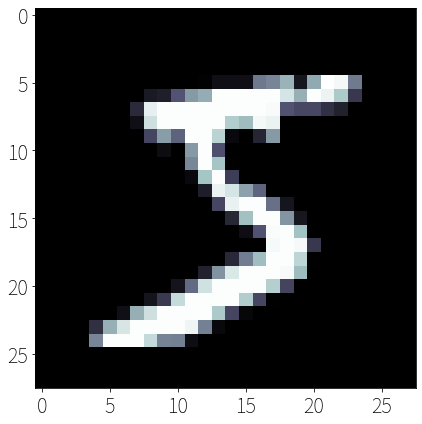

In [40]:
plt.imshow(X[0], cmap='bone', interpolation='nearest')

In [21]:
type(X)

numpy.ndarray

In [22]:
# 转为浮点张量 归一化 再缩放到-1 ~ 1 有利于模型的训练
X = 2 * tf.convert_to_tensor(X, dtype=tf.float32) / 255. - 1

In [23]:
X[1]

<tf.Tensor: shape=(28, 28), dtype=float32, numpy=
array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]], dtype=float32)>

In [24]:
# y转换为整形张量
y = tf.convert_to_tensor(y, dtype=tf.int32)
y[:10]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int32)>

In [25]:
# one-hot 独热码
y_onehot = tf.one_hot(y, depth=10)
y_onehot[:10]
# n_samples * 10

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [26]:
y_onehot.shape

TensorShape([60000, 10])

## 模型构建
对于多输出节点、批量训练方式，我们将模型写成批量形式：
$$Y = X@W + b$$
其中$𝑿 \in 𝑅^{b × 𝑑_{in}}，𝒃 ∈ 𝑅^{d_{out}}，𝒀 ∈ 𝑅^{b \times d_{out}}，𝑾 \in R^{d_{in} \times d_{out}}，d_{in}表示输入节点数，d_{out}表示输出节点数$
输入节点𝑿形状为$[b, d_{in}]$，表示𝑏个样本的输入数据，每个样本的特征长度为$d_{in}$

输入特征长度$d_{in} = 3，输出特征长度d_{out} = 2$的模型

![模型](./3输入2输出模型.png)

### one-hot编码

In [11]:
y4 = tf.constant([0, 1, 2, 3])
y4 = tf.one_hot(y4, depth=10)  # 指定类别总数为 10
y4

<tf.Tensor: shape=(60000, 10), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)>

输入是一张展平后的图片向量$x \in R^{784}$, 输出是长度为10的向量$o \in R^{10}$

预测模型采用多输入、多输出的线性模型 $o = 𝑾^𝐓𝒙 + 𝒃，$
其中模型的输出记为输入的预测值 ，我们希望 越接近真实标签𝒚越好。一般把输入经过
一次(线性)变换叫作一层网络。

## 误差计算
对于分类问题来说，我们的目标是最大化某个性能指标，比如准确度𝑎𝑐𝑐，但是把准确度当作损失函数去优化时发现$\frac {\partial{acc}} {\partial \theta}$不可导, 无法利用梯度下降算法优化网络参数.一般的做法是，设立一个平滑可导的代理目标函数，比如优化模型的输出 与 One-hot 编码后的真实标签𝒚之间的**距离**(Distance)，通过优化代理目标函数得到的模型，一般在测试性能上也能有良好的表现。因此，相对回归问题而言，分类问题的优化目标函数和评价目标函数是不一致的。
$$W^*, b^* = argmin_{w, b} L(o, y)$$

对n个样本的**均方差损失函数**可以表达为
$$L(o, y) = \frac 1 n \sum_{i=1}^n\sum_{j=1}^{10}(o_j^{(i)} - y_j^{(i)})^2$$

## 存在的问题
1. 线性模型过于简单, 逼近复杂的人脑图片识别模型，很显然不能胜任
1. 表达能力, 表达能力体现为逼近复杂分布的能力。上面的解决方案只使用了少量神经元组成的一层网络模型，相对于人脑中千亿级别的神经元互联结构，它的表达能力明显偏弱


## 解决与优化
### 非线性模型
给线性模型嵌套一个非线性函数, 将其转为非线性模型, 我们把这个非线性函数称为**激活函数**(Activation Function)，用𝜎表示:
$$o = \sigma(Wx + b)$$
![激活函数](./激活函数.png)

ReLU 函数非常简单，在𝑦 = 𝑥的基础上面截去了𝑥 < 0的部分，可以直观地理解为
ReLU 函数仅保留正的输入部份，清零负的输入，具有单边抑制特性。虽然简单，ReLU 函
数却有优良的非线性特性，而且梯度计算简单，训练稳定，是深度学习模型使用最广泛的
激活函数之一。
### 表达能力
通过重复堆叠多次变换来增加其表达能力:
$$
h_1 = ReLU(W_1x + b_1) \\
h_2 = ReLU(W_2h_1 + b_2) \\
o = W_3h_2 + b_3 \\
$$
这种由大量神经元模型连接形成的网络结构称为 **神经网络**(Neural Network)。
![3层神经网络](./神经网络.png)

### 自动求导(Autograd)技术
深度学习框架在计算神经网络每层的输出以及损失函数的过程中，会构建神经网络的计算图模
型，并自动完成任意参数𝜃的偏导数$\frac {\partial L}{\partial \theta}$的计算.

## 网络搭建与模型训练
Tensorflow创建网络:
```
# 创建一层网络，设置输出节点数为 256，激活函数类型为 ReLU
layers.Dense(256, activation='relu')
```

In [12]:
# 利用 Sequential 容器封装 3 个网络层，前网络层的输出默认作为下一层的输入
model = keras.Sequential([
    layers.Dense(256, activation='relu'),  # 隐藏层1
    layers.Dense(128, activation='relu'),  # 隐藏层2
    layers.Dense(10)  # 输出层
])

In [27]:
with tf.GradientTape() as tape:
    # 打平操作，[b, 28, 28] => [b, 784]
    X = tf.reshape(X, (-1, 28 * 28))
    # 1. 得到输出 [b, 784] -> [b, 10]
    out = model(X)
    # 标记 转为独热码
    y_onehot = tf.one_hot(y, depth=10)
    # 2. 计算MSE [b, 10]
    loss = tf.square(out - y_onehot)
    # 计算每个样本的平均误差，[b]
    loss = tf.reduce_sum(loss) / x.shape[0]

# 3. 自动求参数的梯度 w1, w2, b1, b2, b3
grads = tape.gradient(loss, model.trainable_variables)

In [28]:
grads

[<tf.Tensor: shape=(784, 256), dtype=float32, numpy=
 array([[ 197.5, -110.3, -399.5, ...,    1.8,  282.5,   19.2],
        [ 197.5, -110.3, -399.5, ...,    1.8,  282.5,   19.2],
        [ 197.5, -110.3, -399.5, ...,    1.8,  282.5,   19.2],
        ...,
        [ 197.5, -110.3, -399.5, ...,    1.8,  282.5,   19.2],
        [ 197.5, -110.3, -399.5, ...,    1.8,  282.5,   19.2],
        [ 197.5, -110.3, -399.5, ...,    1.8,  282.5,   19.2]],
       dtype=float32)>,
 <tf.Tensor: shape=(256,), dtype=float32, numpy=array([-197.5,  110.3,  399.5, ...,   -1.8, -282.5,  -19.2], dtype=float32)>,
 <tf.Tensor: shape=(256, 128), dtype=float32, numpy=
 array([[ -62.8,  148.1,   -2.8, ...,    1.4, -182.5,   34.4],
        [ -33.2,   52.8,   -0. , ...,    0.2, -101.9,   14.3],
        [-131.5,  335.3,   -2. , ...,    3.1, -496.2,   93.2],
        ...,
        [   4. ,   30. ,   -0.4, ...,    0.1,  -28.8,    3.8],
        [ -45.2,  214.4,   -1.8, ...,    3.4, -376.9,   48.5],
        [ -14.2,    8.3,

In [29]:
# w' = w - lr * grad  更新网络参数
optimizer = optimizers.SGD(learning_rate=0.001)
optimizer.apply_gradients(zip(grads, model.trainable_variables))


<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

```
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
```
INFO（通知）<WARNING（警告）<ERROR（错误）<FATAL（致命的)

|  |base_loging|	屏蔽信息|	输出信息|
|---|---|---|---|
|“0”|	INFO    |	无|         INFO + WARNING + ERROR + FATAL|
|“1”|   WARNING	|INFO|              WARNING + ERROR + FATAL|
|“2”|	ERROR	|INFO + WARNING|	    ERROR + FATAL|
|“3”|	FATAL	|INFO + WARNING + ERROR|	    FATAL|

(60000, 28, 28) (60000,) <dtype: 'float32'> <dtype: 'int32'>
tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(9, shape=(), dtype=int32)
batch: (128, 28, 28) (128,)
0 0 loss: 0.47115659713745117
0 100 loss: 0.22770734131336212
0 200 loss: 0.2046838253736496
0 300 loss: 0.17099882662296295
0 400 loss: 0.167177215218544
1 0 loss: 0.15481291711330414
1 100 loss: 0.15990331768989563
1 200 loss: 0.1568237543106079
1 300 loss: 0.14167198538780212
1 400 loss: 0.1395467221736908
2 0 loss: 0.1307026445865631
2 100 loss: 0.14052455127239227
2 200 loss: 0.13356837630271912
2 300 loss: 0.1250942349433899
2 400 loss: 0.12313482910394669
3 0 loss: 0.11586517095565796
3 100 loss: 0.12789574265480042
3 200 loss: 0.11846554279327393
3 300 loss: 0.1140664592385292
3 400 loss: 0.11198369413614273
4 0 loss: 0.1056993380188942
4 100 loss: 0.11869434267282486
4 200 loss: 0.10776277631521225
4 300 loss: 0.10603638738393784
4 400 loss

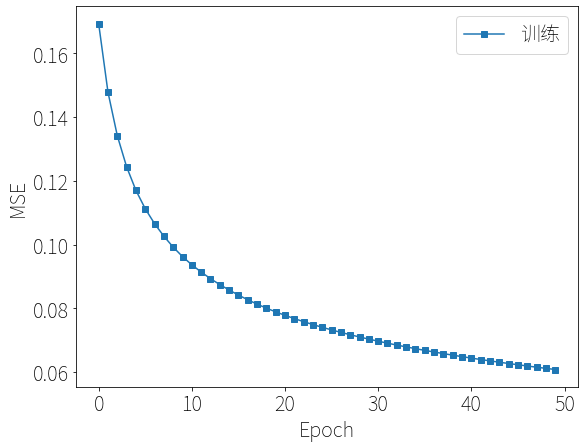

In [44]:
# %load forward.py
import  matplotlib
from 	matplotlib import pyplot as plt
# Default parameters for plots
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.titlesize'] = 20
matplotlib.rcParams['figure.figsize'] = [9, 7]
matplotlib.rcParams['font.family'] = ['Noto Sans CJK JP']
matplotlib.rcParams['axes.unicode_minus']=False 

import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import datasets
import  os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# x: [60k, 28, 28],
# y: [60k]
(x, y), _ = datasets.mnist.load_data()
# x: [0~255] => [0~1.]
x = tf.convert_to_tensor(x, dtype=tf.float32) / 255.
y = tf.convert_to_tensor(y, dtype=tf.int32)

print(x.shape, y.shape, x.dtype, y.dtype)
print(tf.reduce_min(x), tf.reduce_max(x))
print(tf.reduce_min(y), tf.reduce_max(y))

# 每次批量处理128张图片
train_db = tf.data.Dataset.from_tensor_slices((x,y)).batch(128)
train_iter = iter(train_db)
sample = next(train_iter)  # (X[0], y[0])
print('batch:', sample[0].shape, sample[1].shape)


# [b, 784] => [b, 256] => [b, 128] => [b, 10]
# [dim_in, dim_out], [dim_out]
w1 = tf.Variable(tf.random.truncated_normal([784, 256], stddev=0.1))
b1 = tf.Variable(tf.zeros([256]))
w2 = tf.Variable(tf.random.truncated_normal([256, 128], stddev=0.1))
b2 = tf.Variable(tf.zeros([128]))
w3 = tf.Variable(tf.random.truncated_normal([128, 10], stddev=0.1))
b3 = tf.Variable(tf.zeros([10]))

lr = 1e-3  # learning rate: 0.001

losses = []

# mini_batch Gradient descent
for epoch in range(50): # iterate db for 10
    # 每次使用128张图片进行一次梯度下降
    for step, (x, y) in enumerate(train_db):
        # x:[128, 28, 28]
        # y: [128]

        # [b, 28, 28] => [b, 28*28]
        x = tf.reshape(x, [-1, 28*28])

        with tf.GradientTape() as tape: # tf.Variable
            # x: [b, 28*28]
            # h1 = x@w1 + b1
            # [b, 784]@[784, 256] + [256] => [b, 256] + [256] => [b, 256] + [b, 256]
            h1 = x@w1 + tf.broadcast_to(b1, [x.shape[0], 256])
            h1 = tf.nn.relu(h1)
            # [b, 256] => [b, 128]
            h2 = h1@w2 + b2
            h2 = tf.nn.relu(h2)
            # [b, 128] => [b, 10]
            out = h2@w3 + b3

            # compute loss
            # out: [b, 10]
            # y: [b] => [b, 10]
            y_onehot = tf.one_hot(y, depth=10)

            # mse = mean(sum(y-out)^2)
            # [b, 10]
            loss = tf.square(y_onehot - out)
            # mean: scalar
            loss = tf.reduce_mean(loss)

        # compute gradients
        grads = tape.gradient(loss, [w1, b1, w2, b2, w3, b3])
        # print(grads)
        # w1 = w1 - lr * w1_grad
        w1.assign_sub(lr * grads[0])
        b1.assign_sub(lr * grads[1])
        w2.assign_sub(lr * grads[2])
        b2.assign_sub(lr * grads[3])
        w3.assign_sub(lr * grads[4])
        b3.assign_sub(lr * grads[5])


        if step % 100 == 0:
            print(epoch, step, 'loss:', float(loss))

    losses.append(float(loss))

plt.figure()
plt.plot(losses, color='C0', marker='s', label='训练')
plt.xlabel('Epoch')
plt.legend()
plt.ylabel('MSE')
plt.savefig('forward.svg')
plt.show()
